<a href="https://colab.research.google.com/github/taegukang35/rne_pj/blob/main/hallway_unet_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"taegukang0305","key":"139d339eb38ac9ea94d6c43757e6e57a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d taegukang0305/semantic-hallway-dataset

100% 1.28G/1.28G [00:16<00:00, 57.5MB/s]
100% 1.28G/1.28G [00:16<00:00, 83.6MB/s]


In [4]:
!unzip /content/semantic-hallway-dataset.zip

Archive:  /content/semantic-hallway-dataset.zip
  inflating: school_hallway_v2/annotation_train/0.png  
  inflating: school_hallway_v2/annotation_train/1.png  
  inflating: school_hallway_v2/annotation_train/10.png  
  inflating: school_hallway_v2/annotation_train/100.png  
  inflating: school_hallway_v2/annotation_train/1000.png  
  inflating: school_hallway_v2/annotation_train/1001.png  
  inflating: school_hallway_v2/annotation_train/1002.png  
  inflating: school_hallway_v2/annotation_train/1003.png  
  inflating: school_hallway_v2/annotation_train/1004.png  
  inflating: school_hallway_v2/annotation_train/1005.png  
  inflating: school_hallway_v2/annotation_train/1006.png  
  inflating: school_hallway_v2/annotation_train/1007.png  
  inflating: school_hallway_v2/annotation_train/1008.png  
  inflating: school_hallway_v2/annotation_train/1009.png  
  inflating: school_hallway_v2/annotation_train/101.png  
  inflating: school_hallway_v2/annotation_train/1010.png  
  inflating: schoo

In [26]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [13]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 256 # for faster computing on kaggle
IMG_HEIGHT = 256 # for faster computing on kaggle
IMG_CHANNELS = 3
seed = 42

In [9]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256
 
#Capture training image info as a list
train_img = []
 
for directory_path in glob.glob("/content/school_hallway_v2/images_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_img.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_img)
 
#Capture mask/label info as a list
train_mask = [] 
for directory_path in glob.glob("/content/school_hallway_v2/annotation_train"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_mask.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_mask)

In [10]:
X = train_images
Y = train_mask
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
 
x_train = np.asarray(x_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_train = np.asarray(y_train)[:,:,:,0].astype('float32')
y_train =  np.expand_dims(y_train,axis=3)
y_val = np.asarray(y_val)[:,:,:,0].astype('float32')
y_val = np.expand_dims(y_val,axis=3)

In [11]:
x_train.shape

(1378, 256, 256, 3)

In [14]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(x_train[:int(x_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(x_train[:int(x_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(x_train[int(x_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(x_train[int(x_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

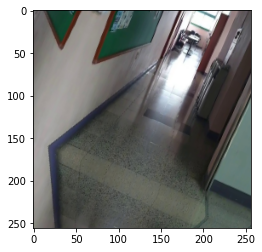

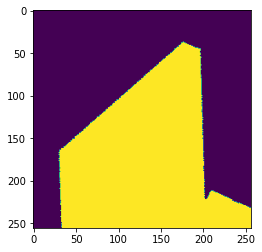

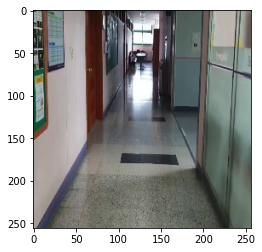

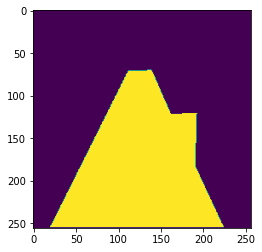

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(x.next()[0].astype(np.uint8))
plt.show()
plt.imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
plt.imshow(x_val.next()[0].astype(np.uint8))
plt.show()
plt.imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [16]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [17]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [18]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [20]:
earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint('model-prgmti1-unet.h5', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=100, callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
250/250 [==============================] - 96s 204ms/step - loss: 0.5596 - acc: 0.6862 - val_loss: 0.5395 - val_acc: 0.7853

Epoch 00001: val_loss improved from inf to 0.53950, saving model to model-prgmti1-unet.h5
Epoch 2/100
250/250 [==============================] - 51s 203ms/step - loss: 0.2494 - acc: 0.8992 - val_loss: 0.1205 - val_acc: 0.9523

Epoch 00002: val_loss improved from 0.53950 to 0.12051, saving model to model-prgmti1-unet.h5
Epoch 3/100
250/250 [==============================] - 51s 203ms/step - loss: 0.1635 - acc: 0.9379 - val_loss: 0.1175 - val_acc: 0.9555

Epoch 00003: val_loss improved from 0.12051 to 0.11754, saving model to model-prgmti1-unet.h5
Epoch 4/100
250/250 [==============================] - 51s 203ms/step - loss: 0.1159 - acc: 0.9551 - val_loss: 0.1118 - val_acc: 0.9551

Epoch 00004: val_loss improved from 0.11754 to 0.11181, saving model to model-prgmti1-unet.h5
Epoch 5/100
250/250 [==============================] - 51s 204ms/step - loss: 0.

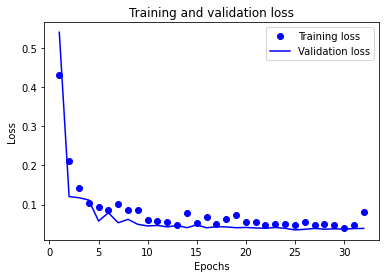

In [21]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

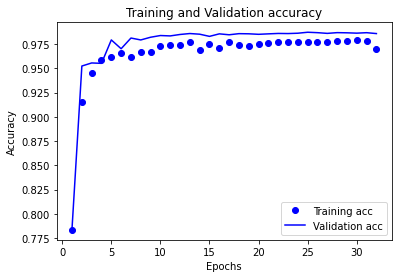

In [22]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs,acc,'bo',label ='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [23]:
nmodel = load_model('/content/model-prgmti1-unet.h5')

In [24]:
def make_mask(img_path):
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  plt.imshow(img)
  plt.show()
  img = np.asarray(img).astype('float32')
  img = np.expand_dims(img,axis=0)
  mask = nmodel.predict(img)
  plt.imshow(mask[0][:,:,0])
  plt.show()

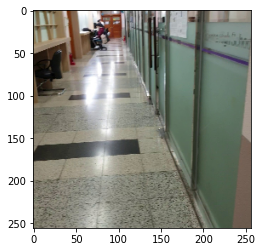

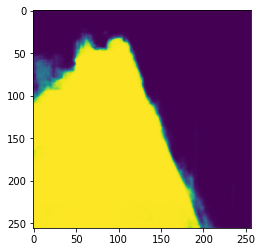

In [75]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway2080.jpg')

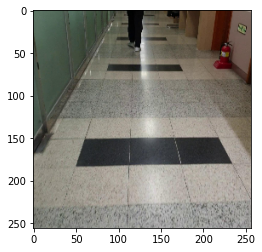

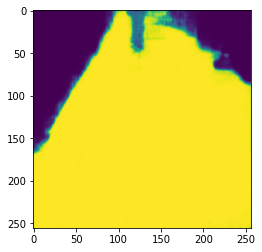

In [76]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway1670.jpg')

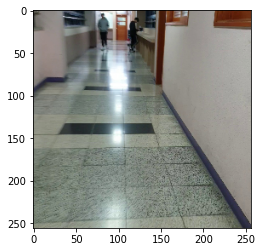

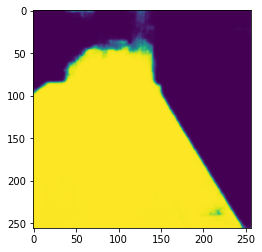

In [77]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway870.jpg')

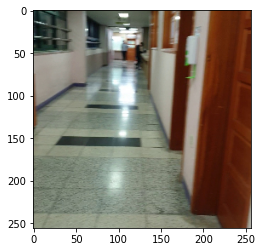

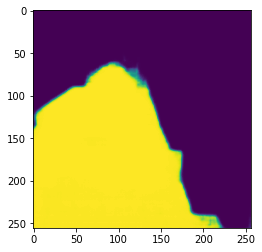

In [78]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway770.jpg')

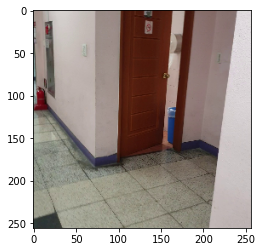

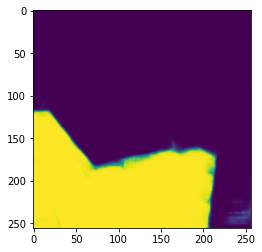

In [79]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway670.jpg')

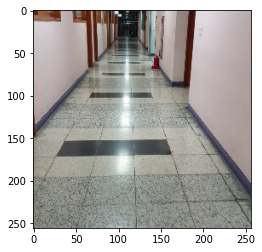

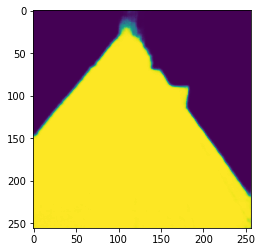

In [80]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway570.jpg')

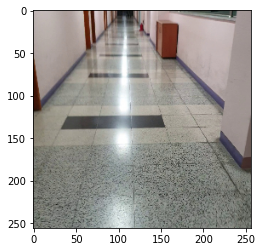

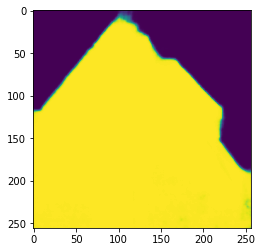

In [83]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway370.jpg')

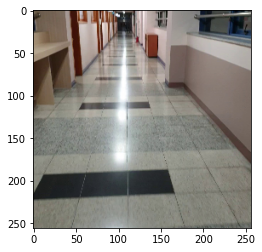

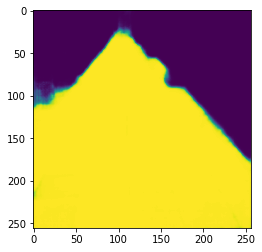

In [84]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway270.jpg')

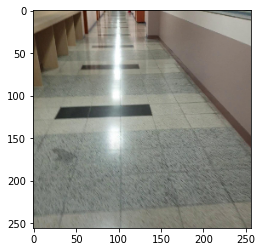

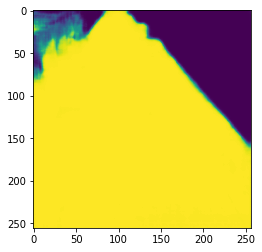

In [85]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway170.jpg')

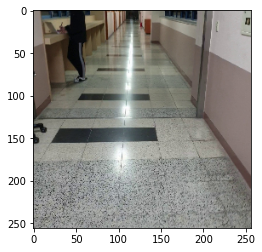

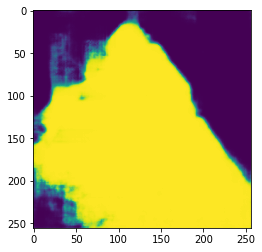

In [86]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway70.jpg')

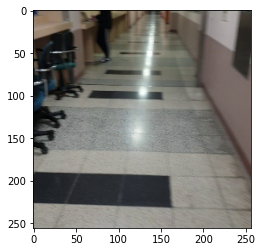

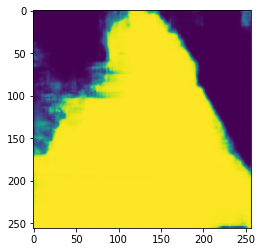

In [87]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway30.jpg')

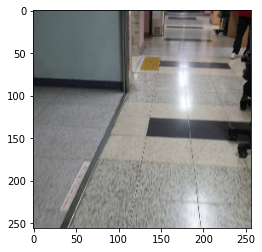

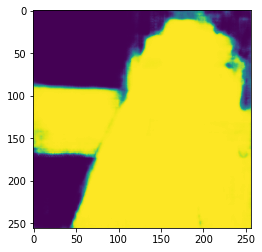

In [88]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway2000.jpg')

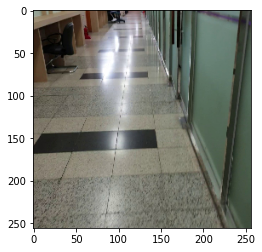

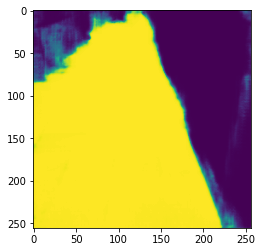

In [91]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway2100.jpg')

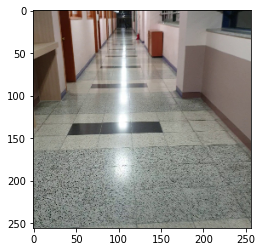

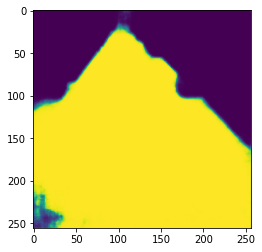

In [101]:
make_mask('/content/drive/MyDrive/stairhallway/hallway/hallway301.jpg')

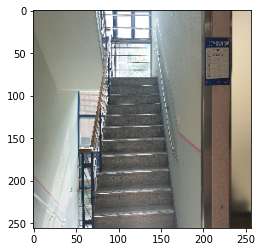

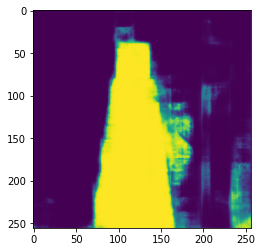

In [102]:
make_mask('/content/drive/MyDrive/myfile/20210701_170043.jpg')

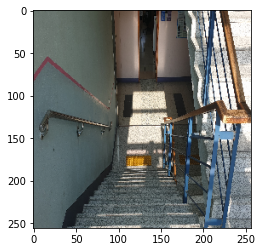

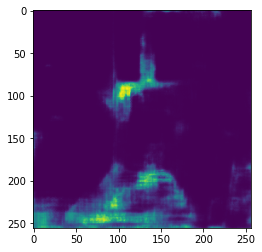

In [103]:
make_mask('/content/drive/MyDrive/myfile/20210701_170159.jpg')

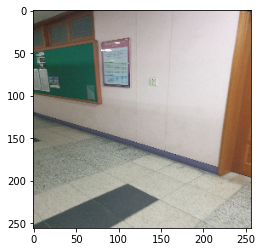

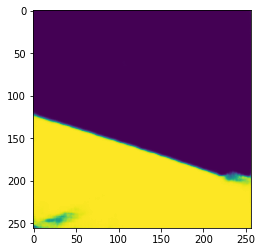

In [113]:
make_mask('/content/drive/MyDrive/stairhallway/test/20201124_211633.jpg')

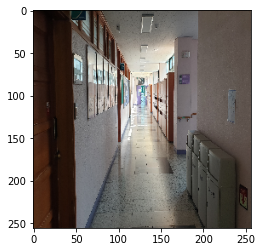

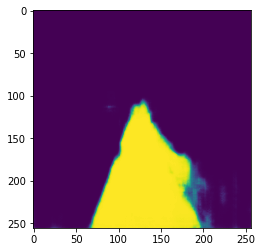

In [107]:
make_mask('/content/drive/MyDrive/myfile/20210702_160614.jpg')

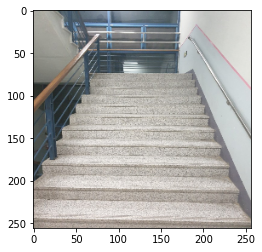

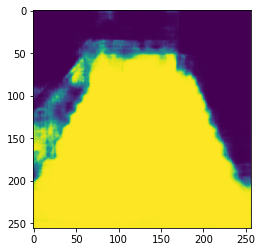

In [114]:
make_mask('/content/drive/MyDrive/stairhallway/test/KakaoTalk_20201124_204024796.jpg')

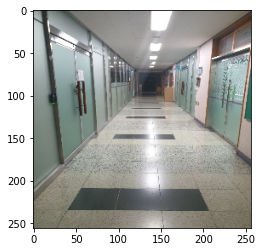

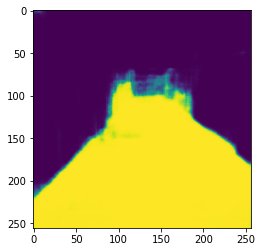

In [117]:
make_mask('/content/drive/MyDrive/stairhallway/test/KakaoTalk_20201124_204027530.jpg')

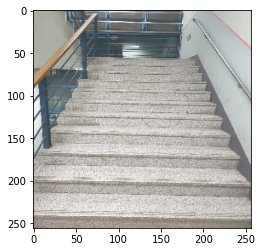

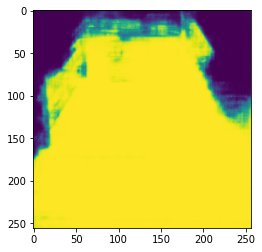

In [118]:
make_mask('/content/drive/MyDrive/stairhallway/test/KakaoTalk_20201124_204028043.jpg')

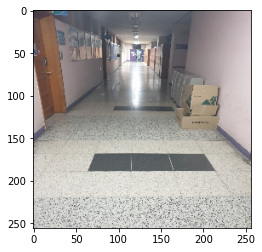

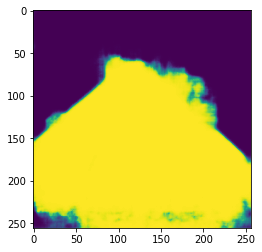

In [120]:
make_mask('/content/drive/MyDrive/stairhallway/test/KakaoTalk_20201124_204028590.jpg')

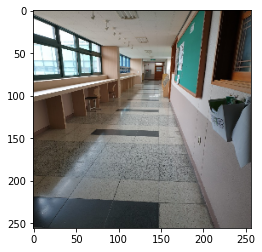

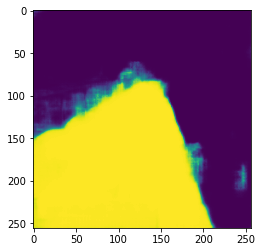

In [123]:
make_mask('/content/drive/MyDrive/stairhallway/test/hallway.jpg')

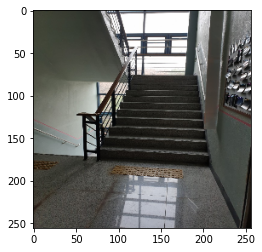

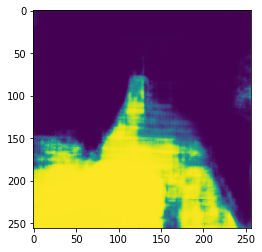

In [124]:
make_mask('/content/drive/MyDrive/stairhallway/test/stiar1.jpg')